In [18]:
%pylab inline
import sklearn.feature_extraction.image
import theanets
import climate
#climate.enable_default_logging()
import glob
pylab.rcParams['figure.figsize'] = (15.0, 10.0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Best parameters:
```
patch_size = 11
patch_center = patch_size / 2
max_patches = 120
n_images = 10

exp = theanets.Experiment(
    theanets.Regressor,
    layers=(
         patch_size**2,
        (patch_size**2, 'relu'),
        (patch_size,    'relu'), 
        (patch_size,    'maxout:4'),
        1
    )
)
exp.itertrain(
    train_batch,
    valid_batch,
    validate_every=5,
    hidden_dropout=0.5,
    visible_dropout=0.5,
```

## Interesting hyperparameters
- Patch size
- n_images
- layer size
- layer count
- maxout vs relu vs other activations?
- Dropout

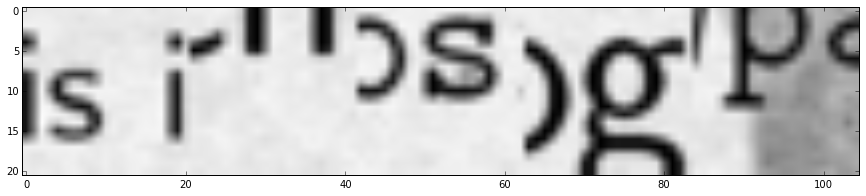

In [19]:
patch_size = 21
patch_center = patch_size / 2
max_patches = 1000
n_images = 40

all_images = [int(filter(char.isdigit, image)) for image in glob.glob("train/*.png")]
all_train_images = [i for i in all_images if i % 5]
all_valid_images = [i for i in all_images if not i % 5]

def batch(mode):
    if mode == 'train':
        images = np.random.choice(all_train_images, n_images)
    else:
        images = np.random.choice(all_valid_images, n_images)

    X_patches = np.zeros((0, patch_size, patch_size))
    y_patches = np.zeros((0, patch_size, patch_size))
    
    for image in images:
        X_image = imread('train/%d.png' % image)
        y_image = imread('train_cleaned/%d.png' % image)
        X_p = sklearn.feature_extraction.image.extract_patches_2d(
            X_image, 
            (patch_size, patch_size), 
            max_patches=max_patches,
            random_state=image)
        X_patches = np.concatenate([X_patches, X_p])
        
        y_p = sklearn.feature_extraction.image.extract_patches_2d(
            y_image,
            (patch_size, patch_size), 
            max_patches=max_patches, 
            random_state=image)
        y_patches = np.concatenate([y_patches, y_p])
        
        #y_differs = (y_patches - X_patches)[:, patch_center, patch_center]
        y_differs = y_patches[:, patch_center, patch_center] > 0.5
        y_differs = y_differs.reshape((y_differs.size, 1))

        
    return (X_patches.reshape(X_patches.shape[0], X_patches.shape[1]*X_patches.shape[2]).astype(np.float32),
            y_differs.astype(np.float32))
def train_batch():
    return batch('train')
def valid_batch():
    return batch('valid')
xs, _ = train_batch()
imshow(np.concatenate(xs[np.random.choice(xs.shape[0], 5)].reshape(5, patch_size, patch_size), axis=1), cmap='gray')

In [20]:
exp = theanets.Experiment(
    theanets.Regressor,
    layers=(
         patch_size**2,
        (int(patch_size**2),  'relu'),
        (int(patch_size**2),  'relu'),
        (255,    'maxout:4'),
        1
    )
)
training_err = []
valid_err = []

Train	Valid	step
0.227139	3.185040	1
0.066229	3.185040	2
0.044323	3.185040	3
0.032332	0.036917	4
0.025576	0.036917	5
0.022071	0.036917	6
0.020158	0.020818	7
0.018713	0.020818	8
0.017842	0.020818	9
0.017180	0.018087	10
0.016808	0.018087	11
0.016238	0.018087	12
0.015747	0.016176	13
0.015325	0.016176	14
0.015023	0.016176	15
0.014553	0.015598	16
0.014245	0.015598	17
0.013796	0.015598	18
0.013473	0.014802	19
0.013220	0.014802	20
0.012814	0.014802	21
0.012321	0.015101	22
0.011975	0.015101	23
0.011462	0.015101	24
0.011019	0.013574	25
0.010482	0.013574	26
0.009977	0.013574	27
0.009621	0.012186	28
0.009039	0.012186	29
0.008770	0.012186	30
0.008329	0.011164	31
0.008010	0.011164	32
0.007627	0.011164	33
0.007340	0.011491	34
0.007208	0.011491	35
0.006853	0.011491	36
0.006633	0.009897	37
0.006327	0.009897	38
0.006167	0.009897	39
0.006016	0.009401	40
0.005827	0.009401	41
0.005668	0.009401	42
0.005429	0.009336	43
0.005325	0.009336	44
0.005329	0.009336	45
0.004999	0.009224	46
0.004874	0.009224	47
0.004

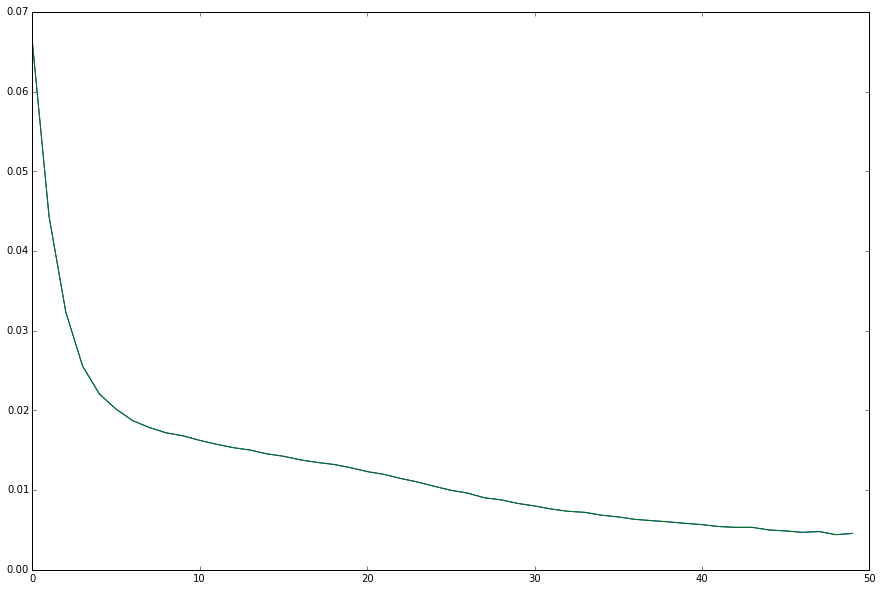

In [21]:
print("Train\tValid\tstep")
i = 0
for train, valid in exp.itertrain(
    train_batch,
    valid_batch,
    algorithm='adam',
    validate_every=3,
    visible_dropout=0.5,
    hidden_dropout=0.25):
    if i > 50:
        break
    else:
        i += 1
    print "%03f\t%03f\t%d" % (train['loss'], valid['loss'], i)
    training_err.append(train['loss'])
    valid_err.append(valid['loss'])
plot(training_err[1:])
plot(training_err[1:])

In [23]:
def apply_model(image, exp):
    patches = sklearn.feature_extraction.image.extract_patches_2d(image, (patch_size, patch_size))
    patches_flat = patches.reshape(patches.shape[0], patches.shape[1]*patches.shape[2])
    denoised_values = exp.network.predict(patches_flat).flatten()
    return denoised_values

In [24]:
image = imread('train/105.png')
clean = imread('train_cleaned/105.png')
denoised = apply_model(image, exp)

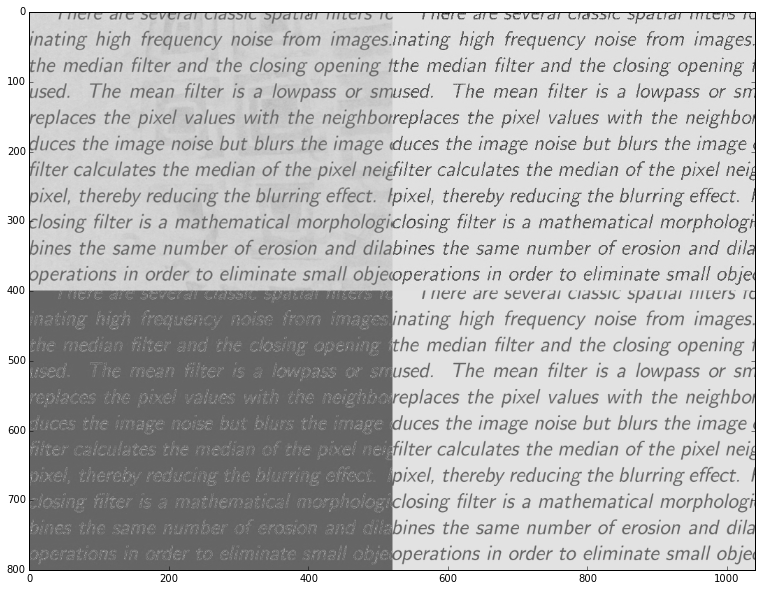

In [25]:
pred = denoised.reshape((image.shape[0]-patch_size+1, image.shape[1]-patch_size+1))
actual = image[patch_center:image.shape[0]-patch_center, patch_center:image.shape[1]-patch_center]
cleaned = clean[patch_center:clean.shape[0]-patch_center, patch_center:clean.shape[1]-patch_center]
diff = np.abs(cleaned - pred)
imshow(
    np.concatenate([
        np.concatenate([actual, pred], axis=1),
        np.concatenate([diff, cleaned], axis=1)
    ]), cmap='gray')

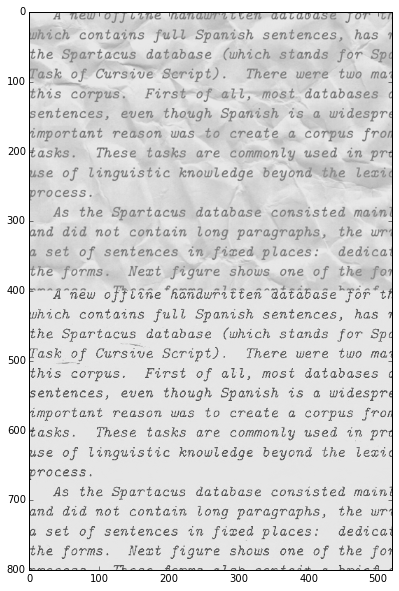

In [32]:
image = imread('test/202.png')
denoised = apply_model(image, exp)
cleaned = denoised.reshape((image.shape[0]-patch_size+1, image.shape[1]-patch_size+1))
actual = image[patch_center:image.shape[0]-patch_center, patch_center:image.shape[1]-patch_center]
imshow(np.concatenate([actual, cleaned], axis=0), cmap='gray')

In [27]:
exp.save('really_good_model')